# 只做ESM sampling

## ESM introduction

### Dataset
- **Data distribution**：1D Gaussian 混合分佈  
  $$p(x) = 0.5\,\mathcal{N}(-2,1^2) + 0.5\,\mathcal{N}(3,0.5^2) $$
- **Sample**：
  - Train set：4000 筆樣本  
  - Validation set：1000 筆樣本  
  - Test set：1000 筆樣本  
  三組樣本互不重疊。

---

### ESM Loss 定義
顯式 Score Matching (ESM) 損失函數：
$$
\mathcal{L}_{\text{ESM}}(x)
= \frac{1}{2}\|s_\theta(x)\|^2 + \operatorname{div}s_\theta(x)
$$
在一維下，散度為：
$$
\operatorname{div}s_\theta(x) = \frac{d s_\theta(x)}{dx}
$$

---

### 訓練與評估流程
1. **Train loss**：用於反向傳遞與更新參數。  
2. **Validation loss**：僅量測模型泛化能力，不更新參數。  
3. **Test loss**：最終評估模型表現。  
4. **視覺化**：
   - Train / Validation loss 曲線
   - Learned score vs True score 比對圖

---

### 目標
觀察模型在 toy 資料上能否學出真實的 score function  
（即 $\nabla_x \log p(x)$）並檢視其收斂行為。


In [31]:
import math, torch, torch.nn as nn
import matplotlib.pyplot as plt
torch.manual_seed(0)
device=torch.device("cpu")


In [10]:
def sample_data(n):
    n1=n//2
    n2=n-n1
    x1=torch.randn(n1)*1.0+(-2.0)
    x2=torch.randn(n2)*0.5+3.0

    return torch.cat([x1, x2], dim=0).unsqueeze(-1)

def logp_x(x):
    logp1 = -0.5*((x+2.0)/1.0)**2 - math.log(math.sqrt(2*math.pi)*1.0)
    logp2 = -0.5*((x-3.0)/0.5)**2 - math.log(math.sqrt(2*math.pi)*0.5)
    m = torch.maximum(logp1, logp2)

    return m+torch.log(0.5*torch.exp(logp1-m)+0.5*torch.exp(logp2-m))

def true_score(x):
    x =x.clone().requires_grad_(True)
    lp = logp_x(x)
    (grad,)= torch.autograd.grad(lp.sum(), x)

    return grad

In [34]:
class ScoreMLP(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(1, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, 1)
        )
        
    def forward(self,x):
        return self.net(x)

lr=5e-4
weight_decay=1e-4
model=ScoreMLP().to(device)
opt = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
    betas=(0.9, 0.999),
    eps=1e-8,
)

ema_model = ScoreMLP().to(device)
ema_model.load_state_dict(model.state_dict())
ema_decay = 0.999

def ema_update():
    with torch.no_grad():
        ms, es = model.state_dict(), ema_model.state_dict()
        for k in ms:
            es[k].mul_(ema_decay).add_(ms[k], alpha=1-ema_decay)


In [35]:
def esm_loss(x):
    x = x.detach().requires_grad_(True)
    s = model(x)
    (div_s,) = torch.autograd.grad(s.sum(), x, create_graph=True)
    return (0.5*s.pow(2) + div_s).mean()

@torch.no_grad()
def esm_loss_eval(x):
    model.eval()
    with torch.enable_grad():
        x = x.clone().requires_grad_(True)
        s = model(x)
        (div_s,) = torch.autograd.grad(s.sum(), x, create_graph = False)
        loss = (0.5*s.pow(2) + div_s).mean().item()
    return loss

# 用 EMA 做 val：
@torch.no_grad()
def esm_loss_eval_with(model_eval, x):
    model_eval.eval()
    with torch.enable_grad():
        x = x.clone().requires_grad_(True)
        s = model_eval(x)
        (div_s,) = torch.autograd.grad(s.sum(), x, create_graph=False)
        return (0.5*s.pow(2) + div_s).mean().item()
    
########
# 更直觀的 score-MSE：
@torch.no_grad()
def score_mse(model_eval, x):
    model_eval.eval()
    s_true = true_score(x); s_hat = model_eval(x)
    return F.mse_loss(s_hat, s_true).item()

## Test

In [36]:
train_x = sample_data(4000)
val_x   = sample_data(1000)
test_x  = sample_data(1000)

BATCH = 1024
EPOCHS = 1000
train_hist, val_hist = [], []

for step in range(1, EPOCHS+1):
    # training
    idx = torch.randint(0, len(train_x), (BATCH,))
    batch = train_x[idx]
    loss = esm_loss(batch)
    opt.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()
    opt.zero_grad(set_to_none=True)
    ema_update()

    # validation
    if step % 10 == 0:
        #val = esm_loss_eval(val_x)
        val = esm_loss_eval_with(ema_model, val_x)
        train_hist.append(loss.item())
        val_hist.append(val)
    if step % 10 == 0:
        print(f"step {step:4d}: train={loss.item():.4f}, val={val:.4f}")


step   10: train=-0.0616, val=0.0226
step   20: train=-0.1019, val=0.0209
step   30: train=-0.1408, val=0.0188
step   40: train=-0.1821, val=0.0167
step   50: train=-0.2637, val=0.0147
step   60: train=-0.3843, val=0.0128
step   70: train=-0.6028, val=0.0109
step   80: train=-0.7709, val=0.0089
step   90: train=-0.9608, val=0.0068
step  100: train=-0.9988, val=0.0044
step  110: train=-1.1202, val=0.0019
step  120: train=-1.2424, val=-0.0007
step  130: train=-1.1635, val=-0.0035
step  140: train=-1.0696, val=-0.0064
step  150: train=-1.1127, val=-0.0094
step  160: train=-1.2960, val=-0.0125
step  170: train=-1.2020, val=-0.0157
step  180: train=-1.1058, val=-0.0191
step  190: train=-1.1886, val=-0.0226
step  200: train=-1.1812, val=-0.0263
step  210: train=-1.1449, val=-0.0301
step  220: train=-1.2615, val=-0.0340
step  230: train=-1.0235, val=-0.0381
step  240: train=-1.2560, val=-0.0424
step  250: train=-1.2178, val=-0.0468
step  260: train=-1.2003, val=-0.0513
step  270: train=-1.060

In [37]:
test_loss = esm_loss_eval(test_x)
print(f"\nFinal test loss = {test_loss:.4f}")


Final test loss = -1.1078


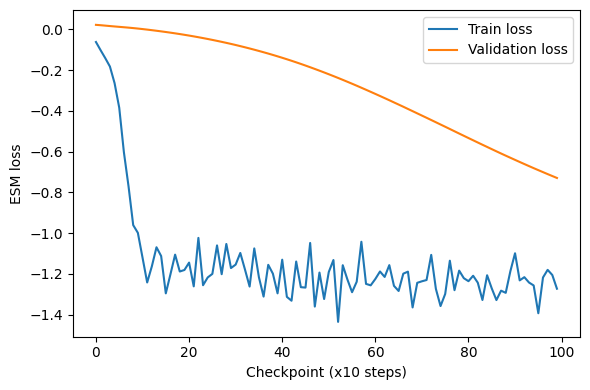

In [38]:
# 畫圖
plt.figure(figsize=(6,4))
plt.plot(train_hist, label="Train loss")
plt.plot(val_hist, label="Validation loss")
plt.xlabel("Checkpoint (x10 steps)")
plt.ylabel("ESM loss")
plt.legend(); plt.tight_layout()
plt.show()

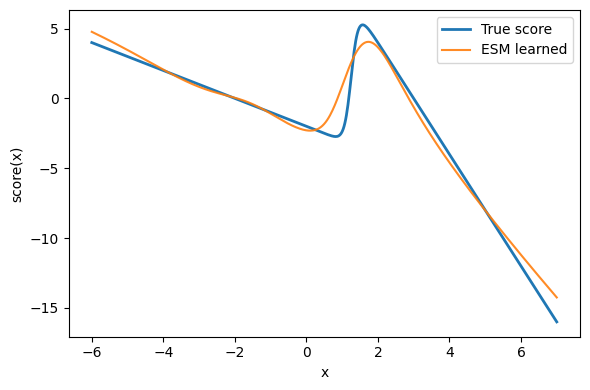

In [39]:
with torch.no_grad():
    grid = torch.linspace(-6,7,600,device=device).unsqueeze(-1)
    s_hat = model(grid).cpu().numpy()
s_true = true_score(grid).cpu().numpy()

plt.figure(figsize=(6,4))
plt.plot(grid.cpu().numpy(), s_true, label='True score', linewidth=2)
plt.plot(grid.cpu().numpy(), s_hat, label='ESM learned', alpha=0.9)
plt.xlabel('x'); plt.ylabel('score(x)')
plt.legend(); plt.tight_layout()
plt.show()

## 試著畫1D 的散點圖

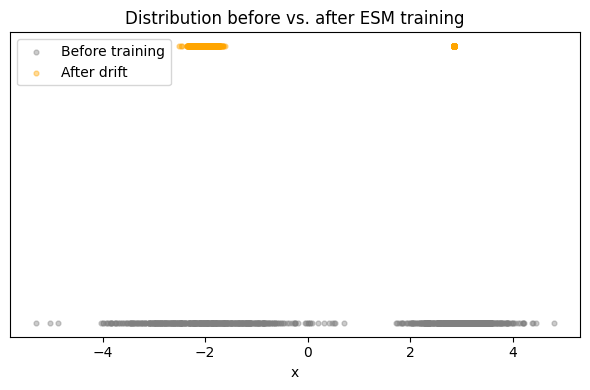

In [40]:
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def sample_drift(model, x, eta=0.1, steps=30):
    """Use learned score field to drift samples toward data density"""
    x = x.clone()
    for _ in range(steps):
        x += eta * model(x)
    return x

# 原始資料分布
x_init = sample_data(1000)
# 根據學到的 score field 更新（模擬一點 diffusion 的反向步）
x_drift = sample_drift(model, x_init, eta=0.05, steps=40)

plt.figure(figsize=(6,4))
plt.scatter(x_init.cpu(), torch.zeros_like(x_init), 
            s=12, alpha=0.4, label='Before training', color='gray')
plt.scatter(x_drift.cpu(), torch.zeros_like(x_drift)+0.1, 
            s=12, alpha=0.4, label='After drift', color='orange')
plt.yticks([]); plt.xlabel("x")
plt.title("Distribution before vs. after ESM training")
plt.legend(); plt.tight_layout()
plt.show()
